In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

bike = pd.read_csv('day.csv')

def preprocess_data(data):
    
    data['dteday'] = pd.to_datetime(data['dteday'])
    
    data['day'] = data['dteday'].dt.day
    data['month'] = data['dteday'].dt.month
    data['year'] = data['dteday'].dt.year
    
    data = pd.get_dummies(data, columns=['season', 'weekday', 'weathersit'], drop_first=True)
    
    data.drop(columns=['instant', 'dteday'], inplace=True)
    
    return data
processed_data = preprocess_data(data)
processed_data.head()

In [137]:
def preprocess_bike_data(bike):

    bike.drop(['instant'], axis=1, inplace=True) 
    bike.drop(['dteday'], axis=1, inplace=True)  
    bike.drop(['casual', 'registered'], axis=1, inplace=True) 
    
    bike = pd.get_dummies(bike, columns=['season', 'mnth', 'weekday', 'weathersit'], drop_first=True)
    
    scaler = StandardScaler()
    numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']
    bike[numerical_columns] = scaler.fit_transform(bike[numerical_columns])
    
    return bike

processed_bike_data = preprocess_bike_data(bike)
processed_bike_data.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,-0.826662,-0.679946,1.250171,-0.387892,985,False,False,...,False,False,False,False,False,False,False,True,True,False
1,0,0,0,-0.721095,-0.740652,0.479113,0.749602,801,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,-1.634657,-1.749767,-1.339274,0.746632,1349,False,False,...,False,False,True,False,False,False,False,False,False,False
3,0,0,1,-1.614780,-1.610270,-0.263182,-0.389829,1562,False,False,...,False,False,False,True,False,False,False,False,False,False
4,0,0,1,-1.467414,-1.504971,-1.341494,-0.046307,1600,False,False,...,False,False,False,False,True,False,False,False,False,False


In [138]:
def train_simple_linear_model(processed_bike_data, target_column, test_size=0.2, random_state=42):
    
    X = processed_bike_data.drop(target_column, axis=1)
    y = processed_bike_data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    y_pred = linear_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}")

    return mse, r2
mse_simple, r2_simple = train_simple_linear_model(processed_bike_data, target_column='cnt')


Mean Squared Error (MSE): 645225.9766327875
R² Score: 0.8390910430289161


In [139]:
def train_enhanced_linear_model(processed_bike_data, target_column, test_size=0.2, random_state=42):

    X = processed_bike_data.drop(target_column, axis=1)
    y = processed_bike_data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_values, p_values = f_regression(X_train, y_train)
    selected_features = X_train.columns[p_values < 0.05]

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_interaction = poly.fit_transform(X_train_selected)
    X_test_interaction = poly.transform(X_test_selected)

    linear_model = LinearRegression()
    linear_model.fit(X_train_interaction, y_train)

    y_pred = linear_model.predict(X_test_interaction)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}")

    return mse, r2
mse_enhanced, r2_enhanced = train_enhanced_linear_model(processed_bike_data, target_column='cnt')

Mean Squared Error (MSE): 564867.3617141597
R² Score: 0.8591311861392056


In [140]:
def train_random_forest(data, target_column='cnt', test_size=0.2, random_state=42, n_estimators=100):
 
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "model": rf,
        "mse": mse,
        "r2": r2
    }

results = train_random_forest(processed_bike_data)

print(f"Mean Squared Error (MSE): {results['mse']}")
print(f"R²: {results['r2']}")

Mean Squared Error (MSE): 530804.763297279
R²: 0.8676258490658109


In [141]:
def train_and_optimize_random_forest(processed_bike_data, test_size=0.2, random_state=42, n_iter=50):
   
    X = processed_bike_data.drop('cnt', axis=1)
    y = processed_bike_data['cnt']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    random_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    rf_random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=random_state),
        param_distributions=random_param_grid,
        n_iter=n_iter,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=random_state
    )

    rf_random_search.fit(X_train, y_train)

    best_rf_model_random = rf_random_search.best_estimator_
    best_params_random = rf_random_search.best_params_

    y_pred_optimized_random = best_rf_model_random.predict(X_test)
    mse_optimized_random = mean_squared_error(y_test, y_pred_optimized_random)
    r2_optimized_random = r2_score(y_test, y_pred_optimized_random)

    return best_params_random, mse_optimized_random, r2_optimized_random
best_params, mse, r2 = train_and_optimize_random_forest(processed_bike_data)
print("Best Parameters:", best_params)
print("MSE:", mse)
print("R2:", r2)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
MSE: 518132.38972159865
R2: 0.8707861347459566


/var/folders/f1/g_8358zx5jzg23sl2tf61fnw0000gn/T/ipykernel_26631/334249915.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='cnt', data=data, palette='Set2')


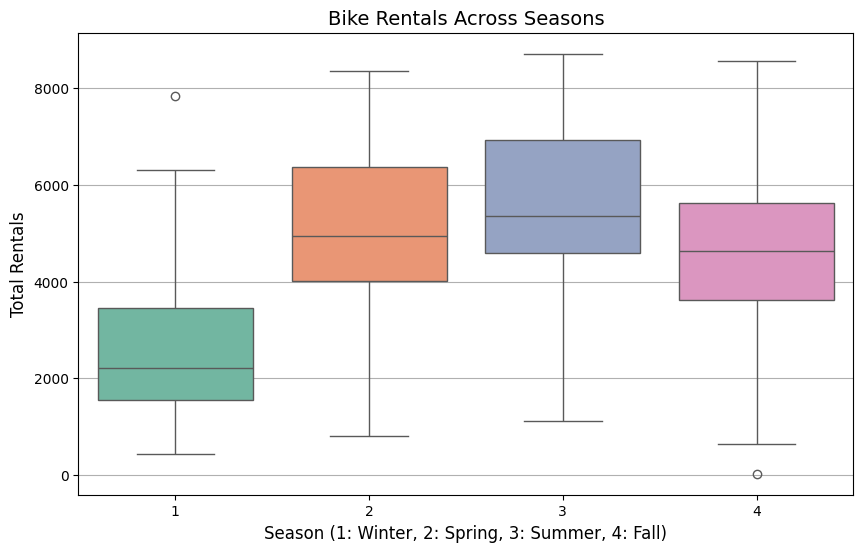

/var/folders/f1/g_8358zx5jzg23sl2tf61fnw0000gn/T/ipykernel_26631/334249915.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weathersit', y='cnt', data=data, palette='coolwarm')


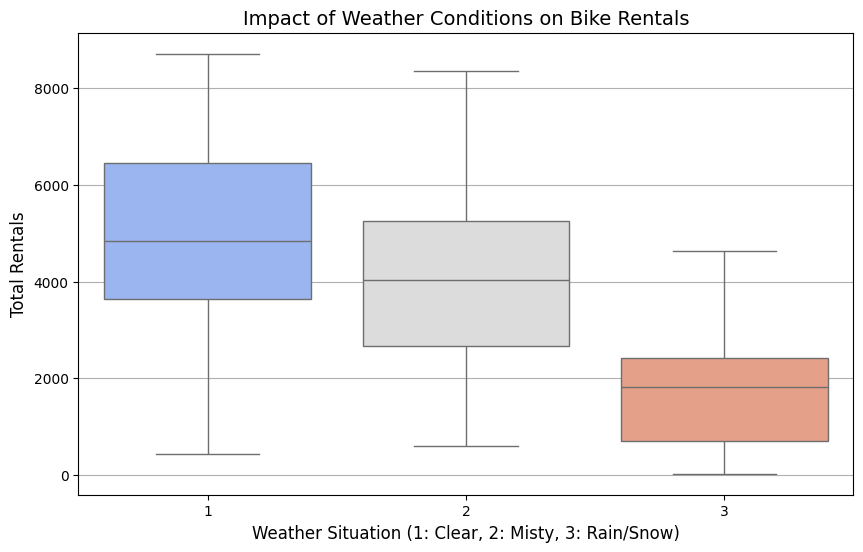

In [144]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='cnt', data=data, palette='Set2')
plt.title('Bike Rentals Across Seasons', fontsize=14)
plt.xlabel('Season (1: Winter, 2: Spring, 3: Summer, 4: Fall)', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.grid(axis='y')
plt.show()

# Impact of weather conditions on rentals
plt.figure(figsize=(10, 6))
sns.boxplot(x='weathersit', y='cnt', data=data, palette='coolwarm')
plt.title('Impact of Weather Conditions on Bike Rentals', fontsize=14)
plt.xlabel('Weather Situation (1: Clear, 2: Misty, 3: Rain/Snow)', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.grid(axis='y')
plt.show()


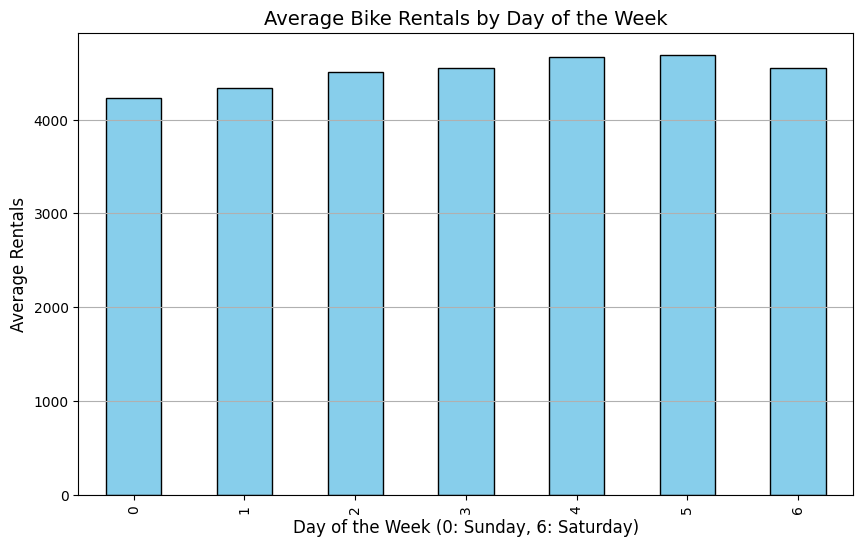

In [147]:
avg_rentals_by_weekday = bike.groupby('weekday')['cnt'].mean()

plt.figure(figsize=(10, 6))
avg_rentals_by_weekday.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Bike Rentals by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week (0: Sunday, 6: Saturday)', fontsize=12)
plt.ylabel('Average Rentals', fontsize=12)
plt.grid(axis='y')
plt.show()